In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from datetime import datetime, timedelta
from pandas.tseries.holiday import USFederalHolidayCalendar

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import normalize, minmax_scale
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import skew
from scipy import stats
from sklearn.model_selection import cross_val_score, train_test_split


### Load Features

##### Don't include temperature data for now 

In [31]:
# Clean data so I have MEF for each region in a file with the region name 
region_df = pd.DataFrame()
nerc_regions = ['TRE', 'MRO', 'WECC', 'SPP', 'SERC', 'RFC', 'FRCC', 'NPCC']
for region in nerc_regions:
    print("currently processing " + region)
    region = 'TRE'
    # Add MEF data to df 
    for year in range(2012, 2018): 
        df = pd.read_csv("data/simulated/dispatch_output_weekly_" + region + "_" + str(year) + "_0co2_v27_coal_vom_same.csv", parse_dates=[0])
        df = df[['datetime', 'demand', 'co2_marg', 'so2_marg', 'nox_marg']]
        region_df = pd.concat((region_df, df))

    # Add temperature data 
    region_df['date'] = pd.DatetimeIndex(region_df['datetime']).normalize()
    temp_df = pd.read_csv("data/temperature/" + region + ".csv")
    temp_df['date'] = pd.to_datetime(temp_df['date'])
    
    # Combine and save the df 
    result_df = pd.merge(temp_df, region_df)
    result_df = result_df[['datetime', 'co2_marg', 'so2_marg', 'nox_marg', 'maxTemp', 'minTemp', 'demand', ]]
    result_df.to_csv("data/mefs/" + region + "_with_temp.csv")

currently processing TRE
currently processing MRO
currently processing WECC
currently processing SPP
currently processing SERC
currently processing RFC
currently processing FRCC
currently processing NPCC


In [41]:
result_df['datetime'] = pd.to_datetime(result_df['datetime'])
result_df = result_df.set_index('datetime')
result_df

KeyError: 'datetime'

In [42]:
result_df

,co2_marg,so2_marg,nox_marg,maxTemp,minTemp,demand
datetime,,,,,,
2012-01-01 00:00:00,369.328381,0.001866,0.102505,55.94,30.92,18215.0
2012-01-01 01:00:00,380.870787,0.001924,0.035481,55.94,30.92,17755.0
2012-01-01 02:00:00,985.614462,2.826002,0.663500,55.94,30.92,17174.0
2012-01-01 03:00:00,380.870787,0.001924,0.035481,55.94,30.92,17670.0
2012-01-01 04:00:00,369.015563,0.001864,0.099055,55.94,30.92,17963.0
...,...,...,...,...,...,...
2017-12-31 19:00:00,394.666737,0.001994,0.081923,53.51,35.51,46017.0
2017-12-31 20:00:00,1046.883693,3.660423,0.299980,53.51,35.51,45355.0
2017-12-31 21:00:00,426.376950,0.002153,0.107935,53.51,35.51,44293.0


In [33]:
# Label the df with the year, month, hour, and season 
def label_year_month(df):
    df = df.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    return df

In [46]:
result_df= label_year_month(result_df)

In [48]:
data = result_df.groupby(['year', 'month']).mean()
data = data.reset_index()
data

,year,month,co2_marg,so2_marg,nox_marg,maxTemp,minTemp,demand
0,2012,1,738.177211,1.704705,0.408311,61.242742,33.042258,25048.407258
1,2012,2,730.932145,1.487322,0.376119,60.007069,37.539655,24847.442529
2,2012,3,764.388128,1.478006,0.303195,74.072097,49.711129,23130.529570
3,2012,4,766.849578,1.125917,0.312044,80.108000,55.859000,25182.768056
4,2012,5,818.653935,1.619235,0.411848,85.950645,62.935323,29195.244624
...,...,...,...,...,...,...,...,...
67,2017,8,707.792937,1.371796,0.346449,89.695806,69.641774,41137.155914
68,2017,9,690.380764,1.314533,0.329809,87.198500,63.324500,34754.331944
69,2017,10,684.315456,1.222119,0.327507,78.341290,51.010323,29420.836022
70,2017,11,708.982068,1.300638,0.327283,70.251500,43.958000,26286.741667


data = data[data['year'].isin(['2014', '2015', '2016'])]
data

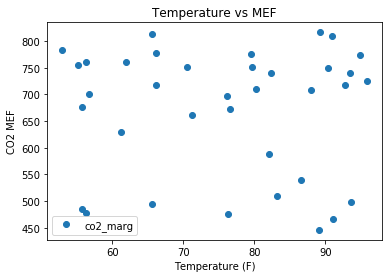

In [51]:
data.plot(x='maxTemp', y='co2_marg', style='o')  
plt.title('Temperature vs MEF')  
plt.xlabel('Temperature (F)')
plt.ylabel('CO2 MEF')

plt.show()

In [ ]:
data = result_df.groupby(['year', 'month']).average()
data = data.reset_index()

In [3]:
# Add columns: is_weekend, is_holiday, month, hour
# Start with TRE as an example
region = "TRE"
df = pd.DataFrame()

for year in range(2012, 2018): 
    region_df = pd.read_csv("data/simulated/dispatch_output_weekly_" + region + "_" + str(year) + "_0co2_v27_coal_vom_same.csv")
    region_df = region_df[['datetime', 'co2_marg', 'so2_marg', 'nox_marg', 'demand', 'co2_tot']]
    df = pd.concat((df, region_df))

df['datetime'] = pd.to_datetime(df['datetime'])

# Create column indicating if date is a holiday 
holidays = USFederalHolidayCalendar().holidays(start='2012-1-31', end='2017-12-31')
df['is_holiday'] = df['datetime'].isin(holidays)
df.is_holiday = df.is_holiday.astype(int)

# Create column with month, and hour 
df['month'] = pd.DatetimeIndex(df.datetime).month 
df['hour'] = pd.DatetimeIndex(df.datetime).hour
df['year'] = pd.DatetimeIndex(df.datetime).year
df['day_of_week'] = pd.DatetimeIndex(df.datetime).weekday

# Include marginal co2 value from the last hour
df['co2_marg_prev_hour'] = df.co2_marg.shift(1)
df = df.dropna()

df

,datetime,co2_marg,so2_marg,nox_marg,demand,co2_tot,is_holiday,month,hour,year,day_of_week,co2_marg_prev_hour
1,2012-01-01 01:00:00,380.870787,0.001924,0.035481,17755.0,1.207889e+07,0,1,1,2012,6,369.328381
2,2012-01-01 02:00:00,985.614462,2.826002,0.663500,17174.0,1.161045e+07,0,1,2,2012,6,380.870787
3,2012-01-01 03:00:00,380.870787,0.001924,0.035481,17670.0,1.204652e+07,0,1,3,2012,6,985.614462
4,2012-01-01 04:00:00,369.015563,0.001864,0.099055,17963.0,1.215692e+07,0,1,4,2012,6,380.870787
5,2012-01-01 05:00:00,936.513299,3.003967,0.207649,18597.0,1.250010e+07,0,1,5,2012,6,369.015563
...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2017-12-31 19:00:00,394.666737,0.001994,0.081923,46017.0,2.726304e+07,0,12,19,2017,6,410.566011
8756,2017-12-31 20:00:00,1046.883693,3.660423,0.299980,45355.0,2.673997e+07,0,12,20,2017,6,394.666737
8757,2017-12-31 21:00:00,426.376950,0.002153,0.107935,44293.0,2.574663e+07,0,12,21,2017,6,1046.883693
8758,2017-12-31 22:00:00,975.438518,5.927592,0.707773,43191.0,2.498122e+07,0,12,22,2017,6,426.376950


##### Graph the dependent variables 

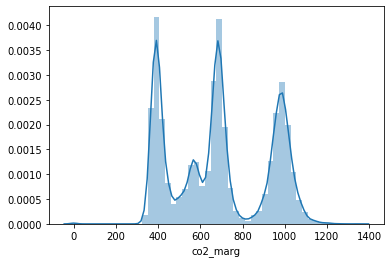

In [5]:
sns.distplot(df['co2_marg'])

##### Correlation Matrix

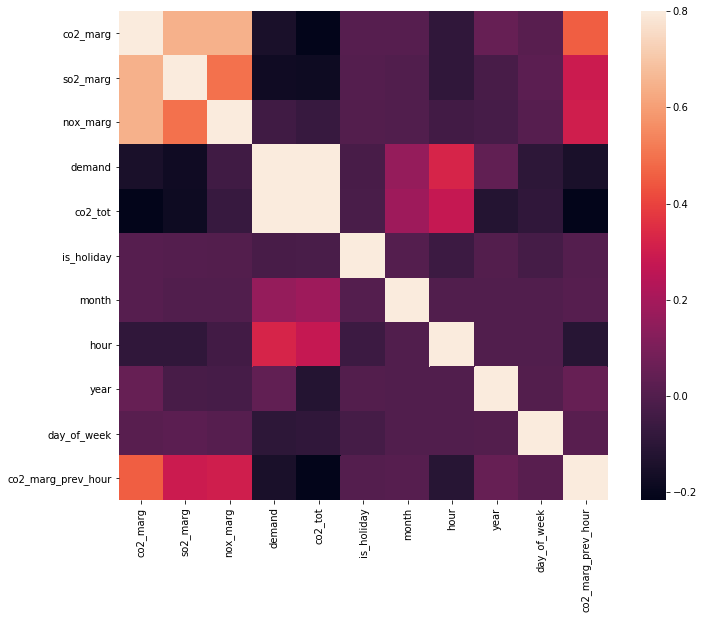

In [9]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

##### Distribution across Years

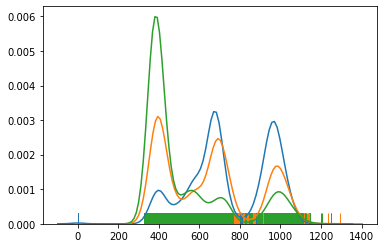

In [15]:
df_2012 = df.loc[df['year'] == 2012]
df_2013 = df.loc[df['year'] == 2013]
df_2014 = df.loc[df['year'] == 2014]

sns.distplot(df_2012[['co2_marg']], hist=False, rug=True)
sns.distplot(df_2013[['co2_marg']], hist=False, rug=True)
sns.distplot(df_2014[['co2_marg']], hist=False, rug=True)

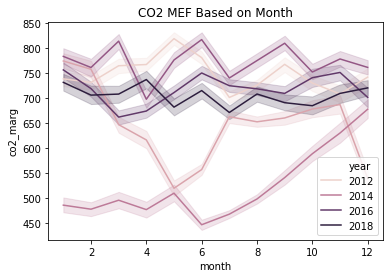

In [4]:
sns.lineplot(x="month", y="co2_marg", hue="year", data=df)

plt.title("CO2 MEF Based on Month")
plt.show()

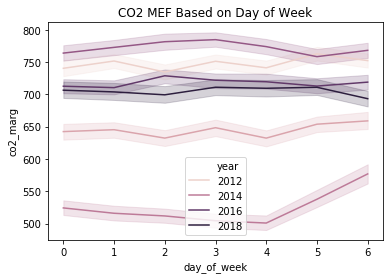

In [5]:
sns.lineplot(x="day_of_week", y="co2_marg", hue="year", data=df)

plt.title("CO2 MEF Based on Day of Week")
plt.show()

NameError: name 'sns' is not defined

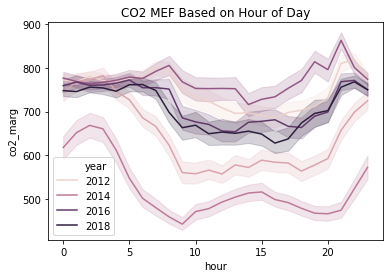

In [6]:
sns.lineplot(x="hour", y="co2_marg", hue="year", data=df)

plt.title("CO2 MEF Based on Hour of Day")
plt.show()

##### Load Features for One Region

Extract information from datetime column (is_weekend, is_holiday, month, hour)

In [4]:
# sin/cos correct of month and hour 
df['cos_month'] = np.cos((df.month)*(2*np.pi/12))
df['sin_month'] = np.sin((df.month)*(2*np.pi/12))
df['cos_hour'] = np.cos((df.hour)*(2*np.pi/12))
df['sin_hour'] = np.sin((df.hour)*(2*np.pi/12))
df['cos_week'] = np.cos((df.day_of_week)*(2*np.pi/12))
df['sin_week'] = np.sin((df.day_of_week)*(2*np.pi/12))

df = df.drop(['month', 'hour', 'day_of_week','datetime'], axis=1)
df

,co2_marg,so2_marg,nox_marg,demand,co2_tot,is_holiday,year,co2_marg_prev_hour,cos_month,sin_month,cos_hour,sin_hour,cos_week,sin_week
1,380.870787,0.001924,0.035481,17755.0,1.207889e+07,0,2012,369.328381,0.866025,5.000000e-01,8.660254e-01,0.500000,-1.0,1.224647e-16
2,985.614462,2.826002,0.663500,17174.0,1.161045e+07,0,2012,380.870787,0.866025,5.000000e-01,5.000000e-01,0.866025,-1.0,1.224647e-16
3,380.870787,0.001924,0.035481,17670.0,1.204652e+07,0,2012,985.614462,0.866025,5.000000e-01,6.123234e-17,1.000000,-1.0,1.224647e-16
4,369.015563,0.001864,0.099055,17963.0,1.215692e+07,0,2012,380.870787,0.866025,5.000000e-01,-5.000000e-01,0.866025,-1.0,1.224647e-16
5,936.513299,3.003967,0.207649,18597.0,1.250010e+07,0,2012,369.015563,0.866025,5.000000e-01,-8.660254e-01,0.500000,-1.0,1.224647e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,394.666737,0.001994,0.081923,46017.0,2.726304e+07,0,2017,410.566011,1.000000,-2.449294e-16,-8.660254e-01,-0.500000,-1.0,1.224647e-16
8756,1046.883693,3.660423,0.299980,45355.0,2.673997e+07,0,2017,394.666737,1.000000,-2.449294e-16,-5.000000e-01,-0.866025,-1.0,1.224647e-16
8757,426.376950,0.002153,0.107935,44293.0,2.574663e+07,0,2017,1046.883693,1.000000,-2.449294e-16,-4.286264e-16,-1.000000,-1.0,1.224647e-16
8758,975.438518,5.927592,0.707773,43191.0,2.498122e+07,0,2017,426.376950,1.000000,-2.449294e-16,5.000000e-01,-0.866025,-1.0,1.224647e-16


In [5]:
# split into dependent and independent 
x = df.iloc[:,3:14]
y = df.iloc[:,0:3]

normalized_df = (x-x.min())/(x.max()-x.min())
normalized_df

,demand,co2_tot,is_holiday,year,co2_marg_prev_hour,cos_month,sin_month,cos_hour,sin_hour,cos_week,sin_week
1,0.145317,0.303952,0.0,0.0,0.273274,0.933013,0.75,0.933013,0.750000,0.0,1.224647e-16
2,0.134442,0.292164,0.0,0.0,0.281814,0.933013,0.75,0.750000,0.933013,0.0,1.224647e-16
3,0.143726,0.303138,0.0,0.0,0.729277,0.933013,0.75,0.500000,1.000000,0.0,1.224647e-16
4,0.149211,0.305916,0.0,0.0,0.281814,0.933013,0.75,0.250000,0.933013,0.0,1.224647e-16
5,0.161079,0.314551,0.0,0.0,0.273043,0.933013,0.75,0.066987,0.750000,0.0,1.224647e-16
...,...,...,...,...,...,...,...,...,...,...,...
8755,0.674360,0.686045,0.0,1.0,0.303787,1.000000,0.50,0.066987,0.250000,0.0,1.224647e-16
8756,0.661968,0.672882,0.0,1.0,0.292022,1.000000,0.50,0.250000,0.066987,0.0,1.224647e-16
8757,0.642088,0.647886,0.0,1.0,0.774612,1.000000,0.50,0.500000,0.000000,0.0,1.224647e-16
8758,0.621460,0.628625,0.0,1.0,0.315485,1.000000,0.50,0.750000,0.066987,0.0,1.224647e-16


### Regression

In [6]:
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state = 100) 

In [7]:
# Focus on CO2 MEF for now 
y_train = y_train['co2_marg']

In [8]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [9]:
# Make predictions using the testing set
results = pd.DataFrame(index = X_test.index)
results['co2_marg_predicted'] = lr.predict(X_test)
results['co2_marg_actual'] = y_test['co2_marg']
results.to_csv("predicted_vs_actual.csv")
results

,co2_marg_predicted,co2_marg_actual
8516,845.965476,396.870625
2658,534.610558,395.204529
1891,764.439849,990.232364
6220,821.696637,687.018638
8442,519.482564,464.267089
...,...,...
7159,801.903145,659.350645
3715,601.044312,429.341020
1232,700.189666,411.882845
2899,812.511559,989.655136


In [15]:
# Coefficients
print('Coefficients: \n', lr.coef_)

Coefficients: 
 [ 4.44281950e-03 -1.16716480e-05  2.25502185e+01 -2.50785248e+00
  4.08837382e-01  7.45249623e-01 -2.38955004e+01  2.76417650e+00
  2.39747768e+00  5.84102151e-01  1.82285299e+00]


In [11]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

In [28]:
# Previous RMSE without previous hour's MEF 

print("RMSE on Training set")
print("CO2:", rmse_cv_train(lr).mean())
print("SO2:", rmse_cv_train(lr).mean())
print("NOX:", rmse_cv_train(lr).mean())
print("\n")

print("RMSE on Test set")
print("CO2:", rmse_cv_test(lr).mean())
print("SO2:", rmse_cv_test(lr).mean())
print("NOX:", rmse_cv_test(lr).mean())

RMSE on Training set
CO2: 222.37727566772406
SO2: 222.37727566772406
NOX: 222.37727566772406


RMSE on Test set
CO2: 129.12920830775448
SO2: 129.12920830775448
NOX: 129.12920830775448


In [12]:
print("RMSE on Training set")
print("CO2:", rmse_cv_train(lr).mean())
print("SO2:", rmse_cv_train(lr).mean())
print("NOX:", rmse_cv_train(lr).mean())
print("\n")

print("RMSE on Test set")
print("CO2:", rmse_cv_test(lr).mean())
print("SO2:", rmse_cv_test(lr).mean())
print("NOX:", rmse_cv_test(lr).mean())

RMSE on Training set
CO2: 203.27909441705611
SO2: 203.27909441705611
NOX: 203.27909441705611


RMSE on Test set
CO2: 116.06848492078814
SO2: 116.06848492078814
NOX: 116.06848492078814
